# Primordial Earth (HERMES tutorial)
There are a wide variety of problems in the conext of the Solar System requiring accurate integration of N-bodies undergoing close encounters and/or collisions. Standard integrators such as IAS15 and WHFast might be insufficient for these types of problems.

In this example we investigate the primordial Earth embedded in a disk of planetesimals, integrating it for a short period of time using the HERMES integrator. HERMES is a hybrid integration scheme which combines the WHFAST and IAS15 algorithms for the optimal balance between speed and accuracy. 

In [1]:
import rebound
import numpy as np

First let's choose the basic properties required for the HERMES integrator. In particular, we are:  
* Setting planetesimals to *semi-active* mode, which means they can influence active bodies but not other semi-active ones.
* Any collision between planetesimals and planets results in a merger, conserving momentum and mass.
* Particles that leave our pre-defined box get removed from the simulation.
* Tracking the energy lost due to ejections or collisions.  

In [2]:
sim = rebound.Simulation()

#integrator options
sim.integrator = "hermes"
sim.ri_hermes.hill_switch_factor = 3.
sim.ri_hermes.radius_switch_factor = 20.
sim.dt = 0.005
sim.testparticle_type = 1

#collision and boundary options
sim.collision = "direct"
sim.collision_resolve = "merge"
sim.collision_resolve_keep_sorted = 1
sim.boundary = "open"
boxsize = 3.
sim.configure_box(boxsize)
sim.track_energy_offset = 1

Now that the setup is complete, it's time to add some particles! When using the HERMES integrator it's always important to add active bodies first and semi-active bodies later. The `N_active` variable separates massive bodies from semi-active/test bodies. Here, we add two active particles, the Sun and the Earth. Thus, `N_active` will be 2.

In [3]:
sim.add(m=1.)
sim.add(m=3e-6,r=5e-5,a=1,e=0.01)
sim.N_active = sim.N

Now, let's create our planetesimal disk. First we define three different distribution functions - powerlaw, uniform and rayleigh.

In [4]:
def rand_powerlaw(slope, min_v, max_v):
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum

def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

Next, let's set up the basic properties of our planetesimal disk. For this simple example we are assuming that all planetesimals have the same mass and radius.

In [5]:
N_pl = 50                            # Number of planetesimals
Mtot_disk = 10.*sim.particles[1].m   # Mass of all planetesimals combined
m_pl = Mtot_disk / N_pl              # Mass of each planetesimal
r_pl = 2e-5                          # Radius of each planetesimal

Now let's add our planetesimals to the simulation!

In [7]:
while sim.N < (N_pl + sim.N_active):
    a = rand_powerlaw(slope=0., min_v=0.95, max_v=1.05) 
    e = rand_rayleigh(sigma=0.01)
    inc = rand_rayleigh(sigma=0.005)
    omega = rand_uniform(0,2*np.pi)
    f = rand_uniform(0,2*np.pi)
    sim.add(m=m_pl, r=r_pl, a=a, e=e, inc=inc, Omega=0, omega=omega, f=f)

Finally, we need to move to the COM frame to avoid drifing out of our simulation box. Also, it is always good practice to monitor the change in energy over the course of a simulation, which requires us to calculate it before and after the simulation.

In [8]:
sim.move_to_com()
E0 = sim.calculate_energy()

We can visualize our setup using rebound.OrbitPlot

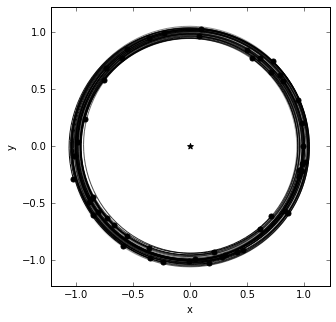

In [10]:
%matplotlib inline
fig = rebound.OrbitPlot(sim, trails=True)

Finally, let's simulate our system for 100 years, and check that our final relative energy error is small. 

In [11]:
sim.integrate(100.)
dE = abs((sim.calculate_energy() - E0)/E0)
print(dE)

2.33556499235e-10
